<a href="https://colab.research.google.com/github/bleamer/eva5/blob/master/w9-Data%20Augmentation/w9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
!pwd

/content/eva5/w8


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

from model.train import train
from model.cnn import Net
from model.resnet import ResNet18
from model.eval import val
from model.utils import cuda_init, cross_entropy_loss, sgd_optimizer, model_summary

from dataset.dataset import cifar10_dataset, cifar10_classes
from dataset.download import download_cifar10

import numpy as np

from tqdm import tqdm


### Init Device

In [ ]:
RAND_VAL = 42

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_WORKER = 64

In [ ]:
cuda, dev = cuda_init(RAND_VAL)
print(cuda, dev)

True cuda


In [ ]:
!nvidia-smi

Sun Sep 20 16:35:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Fetch and Check the data

In [ ]:
transform_train=transforms.Compose([
                        transforms.RandomRotation(12.0),
                        # transforms.RandomErasing(),
                        transforms.RandomHorizontalFlip(0.2),
                        transforms.RandomVerticalFlip(0.1),
                        transforms.ToTensor(),
                        transforms.Normalize((.5,.5,.5),(.5,.5,.5)),
                        # transforms.RandomErasing(0.1),
                        # transforms.RandomHorizontalFlip(0.1),
                        # transforms.RandomVerticalFlip(0.1),
                        # transforms.RandomCrop(0.1), 
                        # transforms.RandomRotation((-7.0, 7.0))
                    ])

DS = download_cifar10()
Classes = cifar10_classes()

data = DS.data
labels = DS.targets

Using downloaded and verified file: /content/eva5/w8/dataset/cifar10/cifar-10-python.tar.gz
Extracting /content/eva5/w8/dataset/cifar10/cifar-10-python.tar.gz to /content/eva5/w8/dataset/cifar10


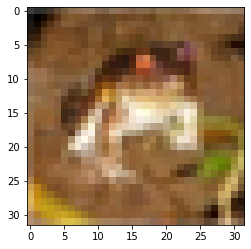

fig:  frog 




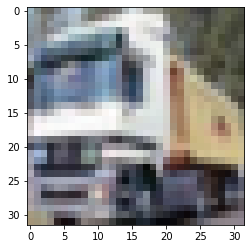

fig:  truck 




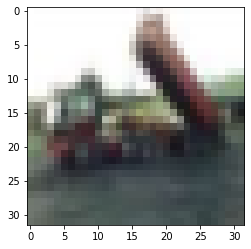

fig:  truck 




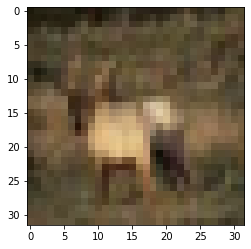

fig:  deer 




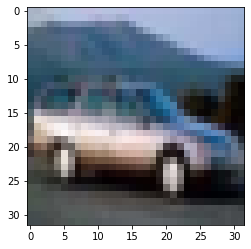

fig:  car 




In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(data[i])
    plt.show()
    print('fig: ',Classes[labels[i]], '\n\n')

### Data Loaders

In [ ]:
train_loader = cifar10_dataset(TRAIN_BATCH_SIZE, cuda, NUM_WORKER, train=True, transforms=transform_train )
test_loader = cifar10_dataset(TEST_BATCH_SIZE, cuda, NUM_WORKER, train = False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
DROPOUT = 0.1
# model = Net(DROPOUT).to(dev)
model = ResNet18().to(dev)

In [ ]:
image_size = np.transpose(data[1],(2,0,1)).shape
model_summary(model, image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

EPOCHS = 30
LEARNING_RATE = 0.01
MOMENTUM = 0.9


losses = []
accuracies = []
incorrect_samples = []

criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd_optimizer(model, LEARNING_RATE, MOMENTUM)  # Create optimizer

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = StepLR(optimizer, step_size=10, gamma=0.3)

for epoch in tqdm(range(1, EPOCHS + 1)):
    print(f'Epoch {epoch}:')
    train(model, train_loader, dev, optimizer, criterion)
    # scheduler.step()
    val(model, test_loader, dev, criterion, losses, accuracies, incorrect_samples)

  0%|          | 0/782 [00:00<?, ?it/s]
Validation set: Average loss: 0.0179, Accuracy: 6070/10000 (60.70%)

Epoch 2:
  0%|          | 0/782 [00:00<?, ?it/s]
Validation set: Average loss: 0.0127, Accuracy: 7276/10000 (72.76%)

Epoch 3:
  0%|          | 0/782 [00:00<?, ?it/s]
Validation set: Average loss: 0.0116, Accuracy: 7539/10000 (75.39%)

Epoch 4:
  0%|          | 0/782 [00:00<?, ?it/s]
Validation set: Average loss: 0.0093, Accuracy: 7970/10000 (79.70%)

Epoch 5:
  0%|          | 0/782 [00:00<?, ?it/s]
Validation set: Average loss: 0.0101, Accuracy: 7818/10000 (78.18%)

Epoch 6:
  0%|          | 0/782 [00:00<?, ?it/s]
Validation set: Average loss: 0.0087, Accuracy: 8172/10000 (81.72%)

Epoch 7:
  0%|          | 0/782 [00:00<?, ?it/s]
Validation set: Average loss: 0.0083, Accuracy: 8250/10000 (82.50%)

Epoch 8:
  0%|          | 0/782 [00:00<?, ?it/s]
Validation set: Average loss: 0.0077, Accuracy: 8380/10000 (83.80%)

Epoch 9:
  0%|          | 0/782 [00:00<?, ?it/s]
Validation set: 

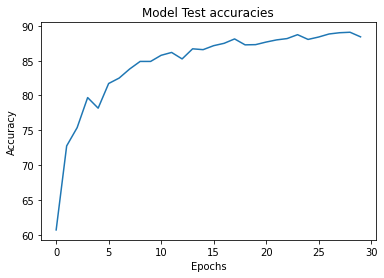

In [ ]:
fig, ax = plt.subplots()
ax.plot(accuracies)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Model Test accuracies')
plt.savefig('Accuracies.png')
plt.show()

In [ ]:
total_params = sum(param.numel() for name, param in  model.named_parameters())


In [ ]:
readme = f'''

# Network Architectures
This notebook implements CIFAR10 classification using ResNet NN architecture using PyTorch 

The results with using ResNet18 architecture with (2,2,2,2), that is, 4 residual blocks of size 2 each.
 
----
| Attribute | Value |
|:--- | :--- |
| Test Accuracy | {np.max(accuracies)} |
| Trained Parameter count   |{total_params} |
| Dropout | {DROPOUT} |
| Total Epochs | {EPOCHS} |
| Batch Size | {TRAIN_BATCH_SIZE}|

----

![](Accuracies.png)

The model uses:
* 3x3 Convolution
* Batch Normalization
* Max Pooling
* 4 X Residual networks of size 2 

To run 

You can install dependencies using  
`$ pip install -r req.txt`

'''

with open('README.md', 'w') as f:
    f.write(readme)